# Introduction to Digital Forensics - Assignment 3
### 1


### 2

### 3


### Made by group 1:
- Simge Bilen       s2532239
- Mark Boom         s2552469
- Tom Essers        s2484765
- Baran Gülbey      s2616394
- Jelmer Hofman     s2460653
- Stijn Schuurman   s2620162

In [3]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install openpyxl
!pip3 install tabulate

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
from tabulate import tabulate


In [6]:
#csv file
file =  'jabber_chat_2021_2022_translated.csv'

df = pd.read_csv(file)
test = ""
len(test)

0

# **(1) How many bad words are in the messages?** (Mark)

In [4]:
# code block for "How many bad wordsa re in the messages? (Mark)"

# **(2) In what time zones do the hackers probably live?** (Mark)

In [5]:
# code block for "In what time zones do the hackers probably live? (Mark)"

# **(3) At what time are the hackers the most active?** (Stijn)

(array([ 313.,  408.,  321.,  388.,  249.,  531.,  839., 1977., 2759.,
        3221., 3200., 3582., 4503., 5233., 5257., 4545., 4723., 4946.,
        4393., 3089., 2940., 1952., 1404.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <BarContainer object of 23 artists>)

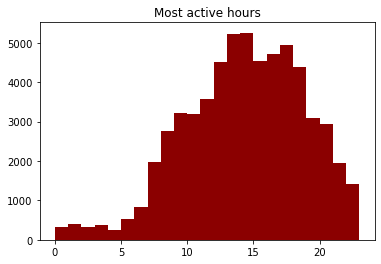

In [6]:
df = pd.read_csv(file, usecols=['ts'])
hours = []
for index, row in df.iterrows():
    hours.append(int(row.ts[11:13]))
plt.title("Most active hours")
plt.hist(hours, color="darkred", bins=range(0, 24))

# **(4) What are the most commonly used words not present in a dictionary?** (Mark)

In [7]:
# code block for "What are the most commonly used words not present in a dictionary? (Mark)"

# **(5) Who sends the most messages?** (Stijn)

<BarContainer object of 10 artists>

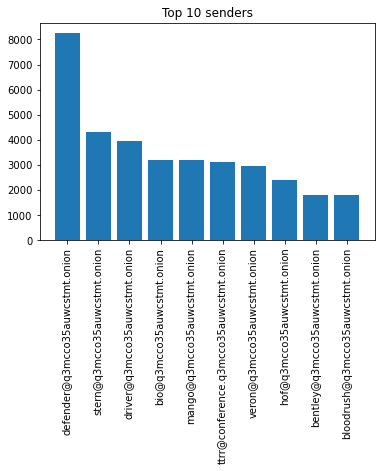

In [8]:
df = pd.read_csv(file, usecols=['sender'])
senders = []
for index, row in df.iterrows():
    senders.append(row.sender)

frequency = collections.Counter(senders)

sendersList = frequency.keys()
frequencyList = frequency.values()

sendersOrdered = [x for _,x in sorted(zip(frequencyList,sendersList), reverse=True)]
frequenciesOrdered = []
# Z is ordered list of most used emails as senders
for x in sendersOrdered:
    frequenciesOrdered.append(frequency.get(x))

plt.title("Top 10 senders")
plt.xticks(rotation=90)
plt.bar(sendersOrdered[:10], frequenciesOrdered[:10])

# **(6) Who receives the most messages?** (Stijn)

<BarContainer object of 10 artists>

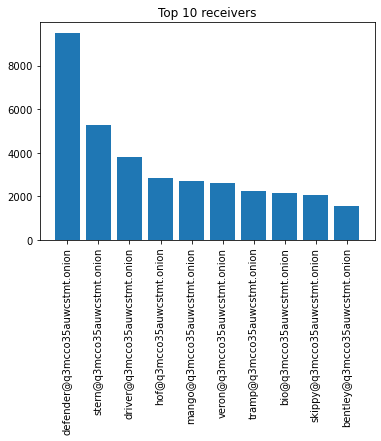

In [9]:
df = pd.read_csv(file, usecols=['to'])
receivers = []
for index, row in df.iterrows():
    receivers.append(row.to)

frequency = collections.Counter(receivers)

receiversList = frequency.keys()
frequencyList = frequency.values()

sendersOrdered = [x for _,x in sorted(zip(frequencyList,receiversList), reverse=True)]
frequenciesOrdered = []
# Z is ordered list of most used emails as senders
for x in sendersOrdered:
    frequenciesOrdered.append(frequency.get(x))

plt.title("Top 10 receivers")
plt.xticks(rotation=90)
plt.bar(sendersOrdered[:10], frequenciesOrdered[:10])

# **(7) What are some movies or songs the hackers reference?** (Mark)

In [10]:
# code block for "What are some movies or songs the hackers reference?"

# **(8) Bitcoin wallets that are mentioned** (Baran)

In [12]:
#receives a string and splits it up at every whitespace. Than iterates over every word so it finds every potential wallet
from urllib.request import AbstractDigestAuthHandler

#finds all word strings that could potentially be a bitcoin wallet, and returns if a match has been made.
def potentialWalletFinder(stringOfCell):
    cryptoBegin = ["1", "3", "b"] #bitcoin wallets normally start with these characters
    splittedCell = stringOfCell.split(' ')
    for word in splittedCell:
        if len(word) > 1: #check if word is actually a word and not a single character
            if word[0] in cryptoBegin: #check if the first character of the word is that of a potential bitcoin wallet
                if len(word) in range(31, 35): # officieel tussen 27 en 34 length bitcoin wallet
                    return word
    return 0                

#there are alot of repeat messages in the cvs file which we definitly know it does not include a bitcoin wallet, so we filter those out initially.
def cleanUp(unCleanedString):
    errorStrings = ["[ERROR: This message is encrypted, and you are unable to decrypt it.]", "[Ошибка: сообщение зашифровано, и невозможно его расшифровать.]"] #encrypted messages
    unwantedSubstrings = ["-----BEGIN PGP PUBLIC KEY BLOCK-----", ".onion", "192.168.", "188.130."] #lots of repeated words
    if unCleanedString in errorStrings:
        return 0
    for index in unwantedSubstrings:
        if index in unCleanedString:
            return 0
    return unCleanedString

#turn the list of unique wallets into a list of lists so it can be turned into a table, connect the frequency with every unique wallet address
def setTable(unique, frequency):
    tableFormatted = []
    count = 0
    for index in unique:
        tempList = []
        tempList.append(count + 1)
        tempList.append(index)
        tempList.append(frequency[count])  
        count += 1
        tableFormatted.append(tempList)
    return tableFormatted

#defining a method which gets the wallets from a cvs
def getWallets(dataFile):
    df = pd.read_csv(dataFile, usecols=['body']) #read all rows in the body column
    wallets = []
    for index, row in df.iterrows():
        cleanedUp = cleanUp(row.body)
        if cleanedUp != 0:
            temp = potentialWalletFinder(cleanedUp)
            if temp != 0:
                wallets.append(temp)
    return wallets

#defining a method which gets the unique wallets from a cvs
def getUniqueWallets(dataFile):
    df = pd.read_csv(dataFile, usecols=['body']) #read all rows in the body column
    wallets = []
    for index, row in df.iterrows():
        cleanedUp = cleanUp(row.body)
        if cleanedUp != 0:
            temp = potentialWalletFinder(cleanedUp)
            if temp != 0:
                if temp not in wallets:
                    wallets.append(temp)
    return wallets

#method to find out how many times each wallet address are within the cvs file
def getWalletFrequency(wallets, unique):
    frequency = []
    for i in unique:
        frequency.append(wallets.count(i))
    return frequency

unique = getUniqueWallets(file)
frequency = getWalletFrequency(getWallets(file), unique)
data = setTable(unique, frequency)
print(tabulate(data, headers=["Nr.", "Bitcoin address", "Frequency"]))



  Nr.  Bitcoin address                       Frequency
-----  ----------------------------------  -----------
    1  3ESoHHu87mTrFNSNUaMVEfT3vYwRYGfSHQ           40
    2  1PemRXvQ5nbDs6q19pCUzfd4kXVGovVoe3            3
    3  1                                             1

       [allen]
       15.06.2021
       отпуск
       не
    4  14HnaQfsQdtgVSNR91jLcbcKtdyddDfP6D            2
    5  15gjb8F5Zd8XRKBCgVxsr8ZuVzr7yBtnCN            1
    6  1DSp4woswZECAL9zdmmGeu1s7k1sGExFDh            5
    7  1HtyXyCrshiJmLYNru7atpDMJrzG9mzwzf            5
    8  b58c7d4c1824eefc874dd7f07eacec58              1
    9  1KfDPgc6CiWb6Fnin1bLWi2moX1ViXANxW            4
   10  1AXiwETqqQoA52Jk5CmJkbAPuW8nR7VUYz            1
   11  1hLvH27BxAPbqx3R2fMCuuMPfS2gGDBJL             1
   12  3N4oho2uXfkFBfUAPtoPGLUXjHXqXV4vrJ            7
   13  1347fBtFzZCrPq29yjRpct5f6Kq5uHZHHy            1
   14  36UqDj8hGfZTVjpURvSnKtpJnJKjhYcvuY            1
   15  314f41b2d78ec803c74a2c89fa8e8bb4              2
   16  

# **(9) Fun conversations** (Baran)

In [13]:
# code block for "Fun conversations"

# **(10) What are the topics referred to in the most messages sent to a hacker?** (Stijn)

In [13]:
# code block for "What are the topics referred to in the most messages sent to a person?"
df = pd.read_csv(file, usecols=['body_en', 'to'])
receivers = []
for index, row in df.iterrows():
    if (row.to == 'defender@q3mcco35auwcstmt.onion'):
        for string in row.body_en.split(' '):
            print(string)
    else:
        print('not from sender')
    receivers.append(row.body_en)

# frequency = collections.Counter(receivers)

# receiversList = frequency.keys()
# frequencyList = frequency.values()

# sendersOrdered = [x for _,x in sorted(zip(frequencyList,receiversList), reverse=True)]
# frequenciesOrdered = []
# # Z is ordered list of most used emails as senders
# for x in sendersOrdered:
#     frequenciesOrdered.append(frequency.get(x))

# plt.title("Top 10 receivers")
# plt.xticks(rotation=90)
# plt.bar(sendersOrdered[:10], frequenciesOrdered[:10])

not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
not from sender
not from sender
not from sender
not from sender
not from sender
not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
not from sender
not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
not from sender
not from sender
not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
not from sender
not from sender
not from sender
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
[Error:
The
message
is
encrypted
and
cannot
be
decrypted.]
[Error:
The
message
is
encrypted
and
cannot
be
d

# **(11) Average of messages per person** (Jelmer)

In [15]:
# code block for "Average of messages per person"

# **(12) Who are the hackers?** (Jelmer)

In [16]:
# code block for "Who are the hackers?"

# **(13) Examples of complains that members had** (Simge)

In [17]:
# code block for "Examples of complaints that members had"

# **(14) What percentage of the messages are encrypted?** (Tom)

In [18]:
# code block for "What percentage of the messages are encrypted?"